In [1]:
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt
from scipy.special import hermite
from scipy.integrate import quad

In [2]:
m = 1.0  # Mass of the particle
hbar = 1.0  # Planck's constant in natural units
x_0 = 1.
omega = hbar / (2 * m * x_0**2)
Nmax = 200  # Maximum Fock state to consider


0.5


/var/folders/0r/nnn8yqwd549bhsr3jqz9kqyh0000gn/T/ipykernel_61730/3584506037.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  coeffs = np.trapz(func, x_vals)


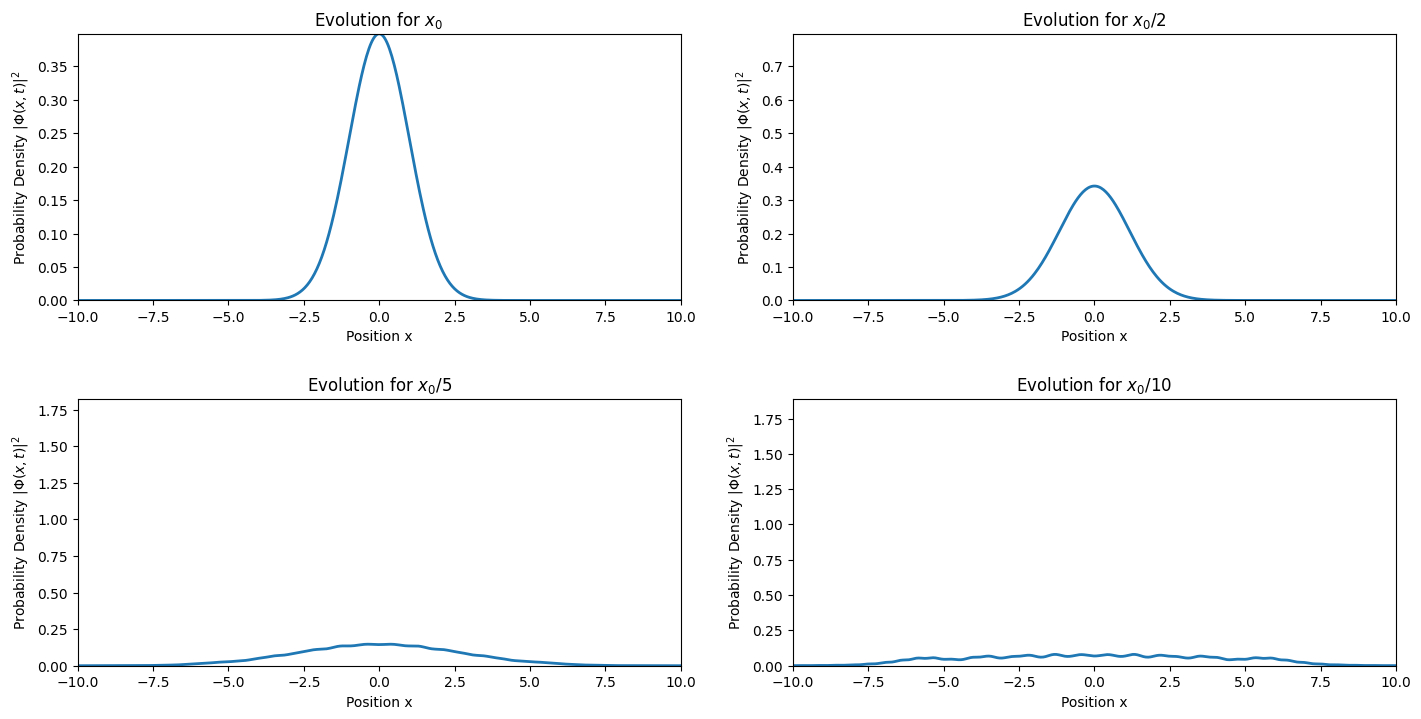

In [3]:
from matplotlib.animation import FuncAnimation, PillowWriter

Nmax = 50  # Maximum Fock state to consider
x_vals = np.linspace(-10 * x_0, 10 * x_0, 500)  # Position space range
time_steps = 400  # Number of time steps for the animation
total_time = 20.0  # Total time for the animation
dt = total_time / time_steps  # Time step duration
print(omega)

##define psi_n by recurrence and this time return all elements
def psi_n_whole(x, n, x_0=1.0):
    psin = []
    
    # Initialize psi_{0} and psi_{1}
    psi_0 = (np.exp(-x**2 / (4 * x_0**2))/ (2 * np.pi * x_0**2)**0.25)  # Psi_0(x)
    psi_1 = x * psi_0 / x_0  # Psi_1(x)
    psin.append(psi_0)
    psin.append(psi_1)
    # Calculate psi_n(x) for 1 <= n <= desired n using recurrence relation
    for i in range(1, n):
        psi_next = (x * psin[i] / x_0  - np.sqrt(i) * psin[i-1]) / np.sqrt(i+1)
        psin.append(psi_next)
    
    # Return complete psi_n
    return psin



# initial wavefunction
phi_x = lambda x, a: np.exp(-((x / (2 * a)) ** 2))/(2 * np.pi * a**2)**0.25


# precompute psi for all n
psi_n_values = np.array(psi_n_whole(x_vals, Nmax))


# Calculate coefficients φ_n for a given initial state Φ(x)
def phi_n(a):
    phi_x_a = phi_x(x_vals, a)
    func = phi_x_a * psi_n_values
    coeffs = np.trapz(func, x_vals)
    return coeffs


# precompute phi_n for different values of a
a_values = [x_0, x_0 / 2, x_0 / 5, x_0 / 10]                      ##-------------------## Changer les valeurs de a ici ##-------------------#
a_strs = ["$x_0$", "$x_0/2$", "$x_0/5$", "$x_0/10$"]

phi_n_coeffs_arr = np.array([phi_n(a) for a in a_values])

# time array
exponentials = np.exp(
    -1j * omega * np.outer(np.arange(Nmax + 1), np.linspace(0, total_time, time_steps))
)

# precompute Time-evolved wavefunction Φ(x, t) using Eq. (76) for each value of a
phi_x_t = np.array(
    [
        (
            psi_n_values[:, :, np.newaxis]
            * exponentials[:, np.newaxis, :]
            * phi_n_coeffs[:, np.newaxis, np.newaxis]
        ).sum(axis=0)
        for phi_n_coeffs in phi_n_coeffs_arr
    ]
)

# Create and save animations for each value of a
# Initialize the plot
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
plt.tight_layout(pad=5.0)
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.set_xlim(x_vals[0], x_vals[-1])
    ax.set_ylim(0, np.max(np.abs(phi_x_t[i]) ** 2))
    ax.set_ylabel("Probability Density $|\Phi(x, t)|^2$")
    ax.set_xlabel("Position x")

line = [axes[i].plot([], [], lw=2)[0] for i in range(4)]
for idx in range(4):
    axes[idx].set_title(r"Evolution for {}".format(a_strs[idx]))


# Animation function
def animate(i):
    for idx, (a, label) in enumerate(zip(a_values, a_strs)):
        line[idx].set_data(x_vals, np.abs(phi_x_t[idx, :, i]) ** 2)
    return line

### seule chose qui change est :  interval=50 (enlever si jamais)
ani = FuncAnimation(fig, animate, frames=time_steps, interval=50, blit=True)

# Sauvegarder comme MP4
ani.save("wavepacket_evolution.mp4", writer="ffmpeg", fps=30)


plt.show()